# Train Model with GPT architecture Using Pre-setting Vocab

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
import torch.backends.cudnn as cudnn

# import custom modules
from models.GPT import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 20
seqlen = 127

In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
config = GPTConfig(vocab_size=charlen, block_size=220, num_props=24)
model = GPT(config).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 3.25M


In [8]:
# train function
def train(model, train_dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(train_dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # concat zeo and syn as the input (prop)
        synthesis_condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_label = tgt[:, 1:].contiguous()
        
        # forward
        optim.zero_grad()
        output = model(idx=tgt_input, prop=synthesis_condition)
        loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
        
        # calculate the accuracy
        pred = torch.argmax(output, dim=-1)
        num_correct = (pred == tgt_label) & (tgt_label != PAD)
        num_words = (tgt_label != PAD).sum().item()
        
        # backward
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(train_dataloader), total_acc / total_num

In [9]:
def evaluate(model, test_dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            # concat zeo and syn as the input (prop)
            synthesis_condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_label = tgt[:, 1:].contiguous()
            # forward
            output = model(idx=tgt_input, prop=synthesis_condition)
            loss = loss_func(output.view(-1, output.size(-1)), tgt_label.view(-1))
            # calculate the accuracy
            pred = torch.argmax(output, dim=-1)
            num_correct = (pred == tgt_label) & (tgt_label != PAD)
            num_words = (tgt_label != PAD).sum().item()
            total_loss += loss.item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(test_dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print('epoch: %d, train loss: %.4f, train acc: %.4f' % (i, train_loss, train_acc))
    test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('epoch: %d test loss: %.4f, test acc: %.4f' % (i, test_loss, test_acc))
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_best_weight_path + 'best_GPT_model.pth')
    torch.save(model.state_dict(), save_best_weight_path + 'last_GPT_model.pth')

100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 0, train loss: 1.0739, train acc: 0.6508


100%|██████████| 68/68 [00:08<00:00,  8.26it/s]


epoch: 0 test loss: 0.6658, test acc: 0.7611


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 1, train loss: 0.6030, train acc: 0.7772


100%|██████████| 68/68 [00:08<00:00,  8.26it/s]


epoch: 1 test loss: 0.5017, test acc: 0.8127


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 2, train loss: 0.4875, train acc: 0.8160


100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


epoch: 2 test loss: 0.4228, test acc: 0.8398


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 3, train loss: 0.4218, train acc: 0.8380


100%|██████████| 68/68 [00:08<00:00,  8.23it/s]


epoch: 3 test loss: 0.3677, test acc: 0.8594


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 4, train loss: 0.3765, train acc: 0.8533


100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


epoch: 4 test loss: 0.3299, test acc: 0.8716


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 5, train loss: 0.3447, train acc: 0.8641


100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


epoch: 5 test loss: 0.3106, test acc: 0.8773


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 6, train loss: 0.3205, train acc: 0.8724


100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


epoch: 6 test loss: 0.2813, test acc: 0.8875


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 7, train loss: 0.3016, train acc: 0.8787


100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


epoch: 7 test loss: 0.2747, test acc: 0.8897


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 8, train loss: 0.2874, train acc: 0.8835


100%|██████████| 68/68 [00:08<00:00,  8.25it/s]


epoch: 8 test loss: 0.2668, test acc: 0.8913


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 9, train loss: 0.2762, train acc: 0.8871


100%|██████████| 68/68 [00:08<00:00,  8.26it/s]


epoch: 9 test loss: 0.2491, test acc: 0.8972


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 10, train loss: 0.2664, train acc: 0.8905


100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


epoch: 10 test loss: 0.2435, test acc: 0.8994


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 11, train loss: 0.2590, train acc: 0.8928


100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


epoch: 11 test loss: 0.2336, test acc: 0.9025


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 12, train loss: 0.2520, train acc: 0.8950


100%|██████████| 68/68 [00:08<00:00,  8.26it/s]


epoch: 12 test loss: 0.2292, test acc: 0.9041


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 13, train loss: 0.2469, train acc: 0.8968


100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


epoch: 13 test loss: 0.2280, test acc: 0.9046


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 14, train loss: 0.2418, train acc: 0.8983


100%|██████████| 68/68 [00:08<00:00,  8.25it/s]


epoch: 14 test loss: 0.2233, test acc: 0.9056


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 15, train loss: 0.2387, train acc: 0.8994


100%|██████████| 68/68 [00:08<00:00,  8.24it/s]


epoch: 15 test loss: 0.2203, test acc: 0.9063


100%|██████████| 284/284 [01:17<00:00,  3.68it/s]


epoch: 16, train loss: 0.2344, train acc: 0.9007


100%|██████████| 68/68 [00:08<00:00,  8.25it/s]


epoch: 16 test loss: 0.2173, test acc: 0.9074


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 17, train loss: 0.2319, train acc: 0.9017


100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


epoch: 17 test loss: 0.2158, test acc: 0.9077


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 18, train loss: 0.2291, train acc: 0.9023


100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


epoch: 18 test loss: 0.2135, test acc: 0.9084


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


epoch: 19, train loss: 0.2265, train acc: 0.9032


100%|██████████| 68/68 [00:08<00:00,  8.26it/s]

epoch: 19 test loss: 0.2102, test acc: 0.9096


In [11]:
def generate_gpt(model, start_sequence, condition_props, max_length, vocab, device, temperature=1.0, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (GPT): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """
    model.eval()
    batch_size = start_sequence.size(0)
    generated_sequences = start_sequence.clone().to(device)  # Clone and move to device

    for _ in range(max_length - start_sequence.size(1)):
        # Get the current sequence length
        current_length = generated_sequences.size(1)

        # Forward pass through the model
        logits = model(generated_sequences, condition_props)  # (batch_size, seq_length, vocab_size)

        # Extract the logits for the last time step
        next_token_logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
            mask = torch.full_like(next_token_logits, float('-inf'))
            mask.scatter_(dim=-1, index=top_k_indices, src=top_k_logits)
            next_token_logits = mask

        # Convert logits to probabilities
        next_token_probs = F.softmax(next_token_logits, dim=-1)

        # Sample from the probability distribution
        next_token = torch.multinomial(next_token_probs, num_samples=1)  # (batch_size, 1)
        
        # Get the most likely next token
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        # Append the generated token to the sequence
        generated_sequences = torch.cat([generated_sequences, next_token], dim=1)

        # Check if all sequences have reached the end token
        if all(next_token[i].item() == EOS for i in range(batch_size)):
            break

    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_sequences:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [12]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_gpt(model, tgt[:, :2], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [02:22<00:00,  2.09s/it]


In [13]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[14:52:10] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32
[14:52:10] SMILES Parse Error: extra open parentheses for input: 'O1C2(OC(C)CC1CC[N+](C)(C)CC2'
[14:52:11] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32
[14:52:11] SMILES Parse Error: extra open parentheses for input: 'O1C2(OC(C)CC1CC[N+](C)(C)CC2'


Validity rate: 0.996
Uniqueness rate: 0.602
Novelty rate: 0.43521594684385384
Reconstructability rate: 0.5647840531561462
Novelty rate: 0.43521594684385384
IntDiv: 0.7624652232391804


[14:52:14] SMILES Parse Error: unclosed ring for input: 'C1C[N+](C)(C)CC2C3C=CC(C4C5C[N+](C)(C)CC45)C12'
[14:52:14] SMILES Parse Error: unclosed ring for input: '[N+]1(C)(C)CC2C3C=CC(C2C1)C1C3C[N+](C)(C)CC31'
[14:52:14] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C1C[N+](C)(C)C2)C1C2C3C[N+](C)(C)CC31'
[14:52:14] SMILES Parse Error: unclosed ring for input: '[N+]1(CC)(CC)CC2C(C3C=CC2C2C[N+](CC)(CC)C2)C1'
[14:52:14] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C1C[N+](C)(C)C2)C1C3C[N+](C)(C)CC3C21'
[14:52:14] SMILES Parse Error: extra close parentheses while parsing: C1CC[N+](C)(CCCC)C)CCC1
[14:52:14] SMILES Parse Error: Failed parsing SMILES 'C1CC[N+](C)(CCCC)C)CCC1' for input: 'C1CC[N+](C)(CCCC)C)CCC1'
[14:52:14] SMILES Parse Error: unclosed ring for input: 'C12C3C=CC(C1C[N+](C)(C)C2)C1C3C[N+](C)(C)CC3C12'
[14:52:14] SMILES Parse Error: unclosed ring for input: '[N+]1(C)(C)CC2C(C3C=CC2C2C3C[N+](C)(C)CC23)C1'
[14:52:14] SMILES Parse Error: extra open parentheses f

FCD score: 0.16692803298055736


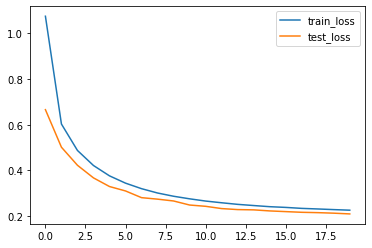

In [14]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'GPT')